# A1: Data Curation

Anmol Srivastava

## Overview

This notebook provides all necessary code (and accompanying documentation) to replicate my submission for A1. This code constructs, processes, analyzes, and visualizes data regarding traffic on English Wikipedia over a given time period. For additional information about references and our final results, please see the README in this directory, as well as the LICENSE. 


## Step 1: Gathering Data

This section is primarily for performing the API calls to access and store all relevant data. 

### Imports

Before we get started, we have several libraries to import into our environment, for use in this section and later portions.

In [1]:
import json
import requests
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

### Useful Constants

Some values in our code (e.g., the URL strings for API call endpoints) are going to be used multiple times without being changed. We define and organize all such constants here.

- `ENDPOINT_LEGACY`: formatted string, used to call API for "pagecount" queries
- `ENDPOINT_PAGEVIEWS`: formatted string, used to call API for "pageviews" queries"
- `PROJECT`: parameter for API calls, never changes
- `HEADERS`: metadata for GET request, IDs user, never changes

In [2]:
ENDPOINT_LEGACY = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'
ENDPOINT_PAGEVIEWS = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'
PROJECT = 'en.wikipedia.org'
HEADERS = {'User-Agent':'https://github.com/Anmol-Srivastava', 'From':'anmols@uw.edu'}

### Useful Functions

Similarly, some functions need to be reusable and modular, and are hence defined here.

- `api_call()`: takes an endpoint (formatted string), and any additional arguments to perform an API query (as a dictionary), returns the JSON-format response for the API call

In [3]:
def api_call(endpoint, query_params):
    query_params['project'] = PROJECT
    call = requests.get(endpoint.format(**query_params), headers=HEADERS)
    response = call.json()
    return response 

### Defining API Queries

We define 5 queries (labelled below in the order they are called), pertaining to the 2 types of calls (desktop, mobile) using the Legacy API and 3 types (desktop, mobile web, mobile app) in the Pageviews API. 

#### Query 1

Monthly desktop-access data from the Legacy API, from January 1, 2008 to July 31, 2016. 

In [4]:
legacy_desktop_params = {
    'access-site':'desktop-site',
    'granularity':'monthly',
    'start':'2008010100',
    'end':'2016073100'
}

legacy_desktop = api_call(ENDPOINT_LEGACY, legacy_desktop_params)

#### Query 2

Monthly mobile-access data from the Legacy API, from January 1, 2008 to July 31, 2016.

In [5]:
legacy_mobile_params = {
    'access-site':'mobile-site',
    'granularity':'monthly',
    'start':'2008010100',
    'end':'2016073100'
}

legacy_mobile = api_call(ENDPOINT_LEGACY, legacy_mobile_params)

#### Query 3

Monthly desktop-access data from the Pageviews API, from July 1, 2015 to August 31, 2020.

In [6]:
pageviews_desktop_params = {
    'access':'desktop',
    'agent':'user',
    'granularity':'monthly',
    'start':'2015070100',
    'end':'2020083100'
}

pageviews_desktop = api_call(ENDPOINT_PAGEVIEWS, pageviews_desktop_params)

#### Query 4

Monthly mobile-web-access data from the Pageviews API, from July 1, 2015 to August 31, 2020. 

In [7]:
pageviews_mobileweb_params = {
    'access':'mobile-web',
    'agent':'user',
    'granularity':'monthly',
    'start':'2015070100',
    'end':'2020083100'
}

pageviews_mobileweb = api_call(ENDPOINT_PAGEVIEWS, pageviews_mobileweb_params)

#### Query 5

Monthly mobile-app-access data from the Pageviews API, from July 1, 2015 to August 31, 2020.

In [8]:
pageviews_mobileapp_params = {
    'access':'mobile-app',
    'agent':'user',
    'granularity':'monthly',
    'start':'2015070100',
    'end':'2020083100'
}

pageviews_mobileapp = api_call(ENDPOINT_PAGEVIEWS, pageviews_mobileapp_params)

### Storing Responses

We output our API call responses as JSON files in this directory, according to the following naming convention:

`apiname_accesstype_yearfirstmonth_yearlastmonth.json`

The filenames themselves are sufficient, but note that the following write commands are performed in the same order that the API calls were made (so the result of Query 1 is saved first below, etc.). 

In [9]:
with open('legacy_desktop_200801_201607.json', 'w') as f:
    json.dump(legacy_desktop, f)

with open('legacy_mobile_200801_201607.json', 'w') as f:
    json.dump(legacy_mobile, f)
    
with open('pageviews_desktop_201507_202008.json', 'w') as f:
    json.dump(pageviews_desktop, f)

with open('pageviews_mobileweb_201507_202008.json', 'w') as f:
    json.dump(pageviews_mobileweb, f)
    
with open('pageviews_mobileapp_201507_202008.json', 'w') as f:
    json.dump(pageviews_mobileapp, f)

## Step 2: Processing Data

This section is for performing some processing steps on the JSON files and creating one overall CSV file, ready for analysis and visualization.

### Reading Files

We have the JSON objects already, but for completeness, we demonstrate reading them in from this repository. The variables assigned to each loaded JSON file are named exactly as in previous steps.

In [10]:
with open('legacy_desktop_200801_201607.json', 'r') as f:
    legacy_desktop = json.load(f)

with open('legacy_mobile_200801_201607.json', 'r') as f:
    legacy_mobile = json.load(f)
    
with open('pageviews_desktop_201507_202008.json', 'r') as f:
    pageviews_desktop = json.load(f)

with open('pageviews_mobileweb_201507_202008.json', 'r') as f:
    pageviews_mobileweb = json.load(f)
    
with open('pageviews_mobileapp_201507_202008.json', 'r') as f:
    pageviews_mobileapp = json.load(f)

### Merging Mobile Traffic Data (Pageviews API)

Here we combine mobile-app and mobile-web data from the Pageviews API into a total mobile traffic count, per month. We achieve this by iterating through each month of available data in the separate datasets (app and web data should have the same number of months available), and adding the views while retaining all of the other common information. This is all fed into one, new variable.

In [11]:
assert len(pageviews_mobileweb['items']) == len(pageviews_mobileapp['items'])
pageviews_mobile_items = []

for i in range(len(pageviews_mobileweb['items'])):
    new_item = pageviews_mobileweb['items'][i]
    new_item['views'] = pageviews_mobileweb['items'][i]['views'] + pageviews_mobileapp['items'][i]['views']
    pageviews_mobile_items.append(new_item)

### Parsing Timestamps

We separate the timestamp values for all data. Each timestamp value is split into year (YYYY numeric format), month (MM numeric format), with the more granular parts (day/hour) discarded. We do this by some simple string operations on each timestamp, since they were entered according to a rigid expected pattern and all follow a `YYYYMMDDHH` format. We do this in a reusable function as below.

- `parse_item_list_timestamps()`: intakes a list of JSON objects (representing the items in an API query's response data), and returns the list with new versions of the objects, which have their `timestamp` attribute replaced with `year` and `month` counterparts

In [12]:
def parse_item_list_timestamps(item_list):
    new_item_list = []
    for item in item_list:
        item = item.copy()
        timestamp = item['timestamp']
        year = timestamp[0:4]
        month = timestamp[4:6]
        item['year'] = year
        item['month'] = month
        item.pop('timestamp')
        new_item_list.append(item)
    return new_item_list

*__Note:__* We call this function on the query response variables' *__item lists__*, and clean up the variables by getting rid of their unnecessary dictionary notation (a result of the JSON format), and only keeping these item lists.

In [13]:
legacy_desktop_items = parse_item_list_timestamps(legacy_desktop['items'])
legacy_mobile_items = parse_item_list_timestamps(legacy_mobile['items'])
pageviews_desktop_items = parse_item_list_timestamps(pageviews_desktop['items'])
pageviews_mobile_items = parse_item_list_timestamps(pageviews_mobile_items)

### Combining All Data

All data from the past queries and processing steps is put into one CSV file in this repository, named `en-wikipedia_traffic_200712-202008.csv`. In any of the views columns, when views total to 0 or are otherwise not represented in the original data, that column has value 0 in the given row. Combination is done through the `pandas` library, which allows for easy operations on tabular data and storage to external files.

First, we define a function to transform the lists of items into table-ready lists.

- `transform_item_list()`: intakes a list of JSON objects (from any query's response data), a string identifying the API source, and a string identifying the access type; returns the new versions of the items, which have been stripped and re-labeled to fit the desired CSV headers -- and finally transformed into a `pandas DataFrame` object

In [14]:
def transform_item_list(item_list, api_source, access_type):
    new_item_list = []
    for item in item_list:
        views = item['count'] if 'count' in item.keys() else item['views']
        new_attribute = '%s_%s_views' % (api_source, access_type)
        new_item = {'year':item['year'], 'month':item['month'], new_attribute:int(views)}
        new_item_list.append(new_item)
    return pd.DataFrame(new_item_list)

We call this function on all of our processed data, with the appropriate flags, to get the `pandas DataFrames`.

In [15]:
df_legacy_desktop = transform_item_list(legacy_desktop_items, 'pagecount', 'desktop')
df_legacy_mobile = transform_item_list(legacy_mobile_items, 'pagecount', 'mobile')
df_pageviews_desktop = transform_item_list(pageviews_desktop_items, 'pageview', 'desktop')
df_pageviews_mobile = transform_item_list(pageviews_mobile_items, 'pageview', 'mobile')

Since each table has standardized `year` and `month` columns, as well as the right column name for its access and API type, we can use join operations to combine all this data. Every time, we perform a full outer join between datasets because we need to have entries for every single row where either dataset has an entry. We sequentially perform these joins until all data is included.

In [16]:
df_merge = df_legacy_desktop.merge(df_legacy_mobile, on=['year', 'month'], how='outer')
df_merge = df_merge.merge(df_pageviews_desktop, on=['year', 'month'], how='outer')
df_merge = df_merge.merge(df_pageviews_mobile, on=['year', 'month'], how='outer')

We replace all `NaN` values with 0 for later calculations. Also, for redundancy, we ensure the views columns are integers.

In [17]:
df_merge = df_merge.fillna(0)

for col in ['pagecount_desktop_views', 'pagecount_mobile_views', 'pageview_desktop_views', 'pageview_mobile_views']:
    df_merge[col] = df_merge[col].astype('int')

Finally, we add the `pagecount_all_views` and `pageview_all_views` columns by performing sum operations between the appropriate pairs of columns. Before saving, we view the final resulting table to ensure values look appropriate.

In [18]:
df_merge['pagecount_all_views'] = df_merge['pagecount_desktop_views'] + df_merge['pagecount_mobile_views']
df_merge['pageview_all_views'] = df_merge['pageview_desktop_views'] + df_merge['pageview_mobile_views']
df_merge

,year,month,pagecount_desktop_views,pagecount_mobile_views,pageview_desktop_views,pageview_mobile_views,pagecount_all_views,pageview_all_views
0,2008,01,4930902570,0,0,0,4930902570,0
1,2008,02,4818393763,0,0,0,4818393763,0
2,2008,03,4955405809,0,0,0,4955405809,0
3,2008,04,5159162183,0,0,0,5159162183,0
4,2008,05,5584691092,0,0,0,5584691092,0
...,...,...,...,...,...,...,...,...
147,2020,04,0,0,3798372613,5505741941,0,9304114554
148,2020,05,0,0,3078093615,5231700095,0,8309793710
149,2020,06,0,0,2721328557,4573975256,0,7295303813
150,2020,07,0,0,2638936132,4809714465,0,7448650597


### Saving File

We are now ready to save this table as a CSV, to the file named `en-wikipedia_traffic_200712-202008.csv` in this repository.

In [19]:
df_merge.to_csv('en-wikipedia_traffic_200712-202008.csv', index=False)

## Step 3: Analyzing Data

Given all of this data, we will visualize mobile, desktop, and 'all' (the total of the two) traffic data via a time series representation. 

### Load CSV

We first load (for completeness) the CSV file we just created, as a new `pandas DataFrame` object.

In [20]:
df = pd.read_csv('en-wikipedia_traffic_200712-202008.csv')

### Visualizing Time Series Data

First, we rework the index of the dataframe we loaded. By setting the index to a transformed version of the `year` and `month` columns (via an in-built date-time convertor in `pandas`), we can easily use that as the x-axis on which the plot is built.

In [21]:
df_reindexed = df.set_index(pd.to_datetime(df[['year', 'month']].assign(day=1)))

Then, we create the subplots on which the visualization will appear. To perform the plotting, we simply plot all of the views columns of the re-indexed dataframe, onto the same `Axis` object. Note that to avoid clutter we only plot non-zero sections of the data.

The final step is cleaning up the chart. We set titles, axis labels, and a custom legend per the colors we manually provided to the plot. The resulting image is below!

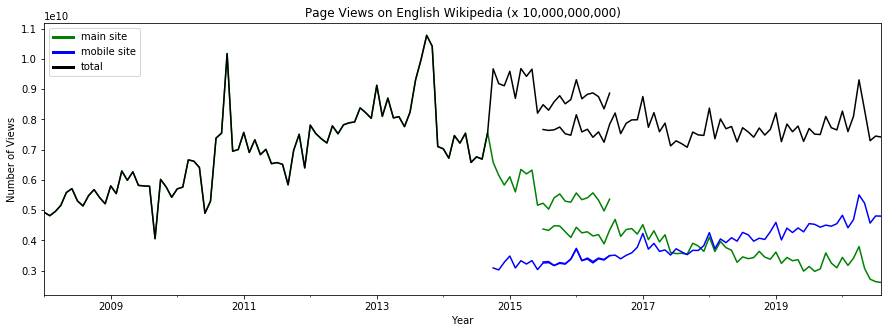

In [22]:
fig, ax = plt.subplots(figsize=(15,5))

ax = df_reindexed[df_reindexed['pagecount_desktop_views'] != 0]['pagecount_desktop_views'].plot(color='green')
ax = df_reindexed[df_reindexed['pagecount_mobile_views'] != 0]['pagecount_mobile_views'].plot(color='blue')
ax = df_reindexed[df_reindexed['pageview_desktop_views'] != 0]['pageview_desktop_views'].plot(color='green')
ax = df_reindexed[df_reindexed['pageview_mobile_views'] != 0]['pageview_mobile_views'].plot(color='blue')
ax = df_reindexed[df_reindexed['pagecount_all_views'] != 0]['pagecount_all_views'].plot(color='black')
ax = df_reindexed[df_reindexed['pageview_all_views'] != 0]['pageview_all_views'].plot(color='black')

ax.set_title('Page Views on English Wikipedia (x 10,000,000,000)')
ax.set_xlabel('Year')
ax.set_ylabel('Number of Views')

colors = ['green', 'blue', 'black']
lines = [Line2D([0], [0], color=c, linewidth=3) for c in colors]
labels = ['main site', 'mobile site', 'total']
ax.legend(lines, labels, loc='upper left')

plt.show()

### Saving Visualization

Finally, we can save the visualization as a PNG file in this same repository, under the filename seen below:

In [23]:
fig.savefig('visalization.png')